# 🧠 D&D Monster Analytics: Ottimizzazione e Analisi Avanzata

**Obiettivo:** Confrontare le prestazioni del modello completo (tutte le feature) con il modello ottimizzato (solo 20 feature) utilizzando metriche avanzate per giustificare la scelta ingegneristica.

### 📋 Metriche Utilizzate
Oltre alle metriche standard, utilizzeremo indicatori specifici per validare la riduzione della complessità:
1.  **Adjusted R²:** A differenza dell'R², penalizza l'aggiunta di feature inutili. Se il modello Lean ha un Adj. R² simile o superiore, la semplificazione è matematicamente corretta.
2.  **Median Absolute Error (MedAE):** Robusto agli outlier (es. Tarrasque). Indica l'errore sul "mostro tipico".
3.  **Max Error:** Il peggior errore commesso in assoluto (worst-case scenario).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, max_error

# Configurazione Plot
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("✅ Librerie caricate.")

✅ Librerie caricate.


## 1. Caricamento Dati e Setup
Carichiamo il dataset pulito e prepariamo i dati.

In [2]:
# Caricamento intelligente (gestisce percorsi diversi)
df = pd.read_csv("./data/monsters_final.csv")

# Preprocessing base
if 'name' in df.columns: df = df.drop(columns=['name'])

# Definizione X e y
X = df.drop(columns=['cr'])
y = df['cr']

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Dataset pronto: {df.shape}")

✅ Dataset pronto: (2435, 72)


## 2. Addestramento dei Modelli (Full vs Lean)
Addestriamo entrambi i modelli per il confronto diretto.

In [3]:
# --- A. FULL MODEL ---
print("⚙️ Training Full Model (tutte le colonne)...")
rf_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_full.fit(X_train, y_train)

# --- B. FEATURE SELECTION ---
# Estraiamo le top 20 feature
importances = rf_full.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
top_20_features = feat_df.sort_values(by='Importance', ascending=False)['Feature'].head(20).tolist()

# Creiamo i dataset ridotti
X_train_lean = X_train[top_20_features]
X_test_lean = X_test[top_20_features]

# --- C. LEAN MODEL ---
print(f"⚙️ Training Lean Model (Top 20 colonne)...")
rf_lean = RandomForestRegressor(n_estimators=100, random_state=42)
rf_lean.fit(X_train_lean, y_train)

print("✅ Entrambi i modelli sono stati addestrati.")

⚙️ Training Full Model (tutte le colonne)...
⚙️ Training Lean Model (Top 20 colonne)...
✅ Entrambi i modelli sono stati addestrati.


## 3. Calcolo Metriche Avanzate
Definiamo una funzione per calcolare tutte le metriche chiave, incluso l'Adjusted R².

In [4]:
def calculate_metrics(model, X_test_data, y_test_data, label):
    # Predizione
    y_pred = model.predict(X_test_data)
    
    # Metriche Standard
    mae = mean_absolute_error(y_test_data, y_pred)
    mse = mean_squared_error(y_test_data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_data, y_pred)
    
    # Metriche Avanzate (Robustezza & Worst Case)
    medae = median_absolute_error(y_test_data, y_pred)
    max_err = max_error(y_test_data, y_pred)
    
    # Adjusted R2 Formula: 1 - (1-R2) * (n-1)/(n-p-1)
    n = len(y_test_data)
    p = X_test_data.shape[1]
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    
    return {
        "Modello": label,
        "Features (p)": p,
        "R2 Score": r2,
        "Adj. R2": adj_r2,
        "MAE (Mean)": mae,
        "MedAE (Median)": medae,
        "RMSE": rmse,
        "Max Error": max_err
    }

# Esecuzione calcoli
metrics_full = calculate_metrics(rf_full, X_test, y_test, "Full Model")
metrics_lean = calculate_metrics(rf_lean, X_test_lean, y_test, "Lean Model")

# Creazione DataFrame Comparativo
results_df = pd.DataFrame([metrics_full, metrics_lean]).set_index("Modello")

# Calcolo Delta
delta = results_df.loc["Lean Model"] - results_df.loc["Full Model"]
delta.name = "Delta (Lean - Full)"
final_table = pd.concat([results_df, delta.to_frame().T])

# Visualizzazione
print("-" * 80)
print("📊 TABELLA DI ANALISI PRESTAZIONI")
print("-" * 80)
print(final_table.round(4).T)

--------------------------------------------------------------------------------
📊 TABELLA DI ANALISI PRESTAZIONI
--------------------------------------------------------------------------------
                Full Model  Lean Model  Delta (Lean - Full)
Features (p)       71.0000     20.0000             -51.0000
R2 Score            0.9463      0.9481               0.0018
Adj. R2             0.9371      0.9459               0.0088
MAE (Mean)          0.8151      0.7923              -0.0228
MedAE (Median)      0.5500      0.4950              -0.0550
RMSE                1.1946      1.1744              -0.0203
Max Error           6.3600      5.8600              -0.5000


### 🔍 Interpretazione dei Risultati
Analizziamo il Delta dell'Adjusted R².

In [5]:
delta_adj_r2 = final_table.loc["Delta (Lean - Full)", "Adj. R2"]

if delta_adj_r2 >= -0.005:
    print(f"✅ SUCCESSO: Il Delta dell'Adjusted R2 è {delta_adj_r2:.4f}.")
    print("   Il modello Lean mantiene (o migliora) l'efficienza informativa rimuovendo il rumore.")
else:
    print(f"⚠️ ATTENZIONE: Il Delta dell'Adjusted R2 è {delta_adj_r2:.4f}.")
    print("   C'è una perdita di informazione. Valutare se mantenere il modello Full.")

✅ SUCCESSO: Il Delta dell'Adjusted R2 è 0.0088.
   Il modello Lean mantiene (o migliora) l'efficienza informativa rimuovendo il rumore.


## 4. Visualizzazione Grafica
Confronto visivo delle metriche più importanti per il report.

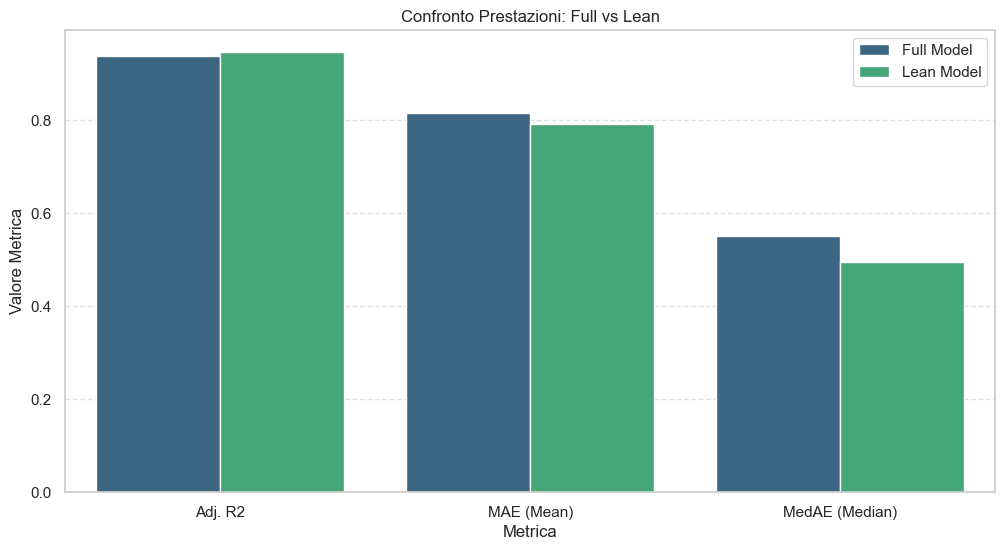

In [6]:
# Prepariamo i dati per Seaborn
plot_data = results_df.reset_index().melt(id_vars="Modello", 
                                          value_vars=["Adj. R2", "MAE (Mean)", "MedAE (Median)"],
                                          var_name="Metrica", value_name="Valore")

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_data, x="Metrica", y="Valore", hue="Modello", palette="viridis")
plt.title("Confronto Prestazioni: Full vs Lean")
plt.ylabel("Valore Metrica")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.show()

## 5. Export Finale
Salviamo il dataset ottimizzato con solo le colonne fondamentali per l'uso futuro.

In [7]:
# Salvataggio
cols_final = top_20_features + ['cr']
df_lean = df[cols_final]
df_lean.to_csv("./data/monsters_lean.csv", index=False)

print(f"✅ Dataset ottimizzato salvato: 'monsters_lean.csv' ({df_lean.shape[1]} colonne)")
print("📂 Colonne salvate:", top_20_features)

✅ Dataset ottimizzato salvato: 'monsters_lean.csv' (21 colonne)
📂 Colonne salvate: ['hit_points', 'armor_class', 'wisdom_save', 'constitution_save', 'damage_resistances_count', 'legendary_actions_count', 'damage_immunities_count', 'intelligence_save', 'passive_perception', 'hit_dice_count', 'charisma_save', 'condition_immunities_count', 'special_abilities_count', 'constitution', 'charisma', 'dexterity_save', 'actions_count', 'skills.stealth', 'strength', 'dexterity']
